## GRS_test for mispricing errors

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from scipy import stats
from tqdm import tqdm
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import autocorrelation_plot

In [2]:
"""
Function GRS_test(factor, resid, alpha) is to conduct GRS test according 
to Gibbons, Ross & Shanken(1989) to receive GRS-statistic and p-value.

H0: alpha1=alpha2=...=alphaN=0

Parameters:
  T = number of months
  N = number of portfolios/stocks
  L = number of factors

Inputs:
  factor: matrix of FF factors with shape (T, L)
  resid: matrix of residuals with shape (T, N)
  alpha: matrix of intercepts with shape (N, 1)

Outputs:
  f_grs: GRS-statistic
  p_grs: P-value

"""
from scipy.stats import f

def GRS_test(factor, resid, alpha):
    N = resid.shape[1]        
    T = resid.shape[0]       
    L = factor.shape[1]      

    if (T-N-L) < 0:
        print('can not conduct GRS test because T-N-L<0')
        return

    factor = np.asmatrix(factor)                   # factor matrix (T, L)
    resid = np.asmatrix(resid)                     # residual matrix (T, N)
    alpha = np.asmatrix(alpha).reshape(N, 1)       # intercept matrix (N, 1)

    mean_return_factor = (factor.mean(axis=0))

    # covariance matrix of residuals
    cov_resid = (resid.T * resid) / (T-L-1)
    # covariance matrix of factors
    cov_factor = ((factor - mean_return_factor).T * (factor - mean_return_factor)) / (T-1)

    mean_return_factor = mean_return_factor.reshape(L, 1)

    # GRS statistic
    # pinv.linalg.pinv is a pseudoinverse not a real one, for calculating the real inverse we need to use np.linalg.inv
    # However, the structure of resids matrix is oftenly a Singular matrix (one for which a inverse matrix does not exis)
    f_grs = float((T/N) * ((T-N-L)/(T-L-1)) * ((alpha.T * np.linalg.pinv(cov_resid) * alpha) / (1 + mean_return_factor.T * np.linalg.pinv(cov_factor) * mean_return_factor)))

    # p-value
    p_grs = 1 - stats.f.cdf(f_grs, N, (T-N-L))

    return f_grs, p_grs


In [21]:
## Jarque-Bera Test
import numpy as np
import scipy.stats as stats

"""
H0: The data is normally distributed; 
H1: The data does not come from a normal distribution.
"""
def self_JBtest(y):
    # n is the size of data
    n = y.size
    y_ = y - y.mean()
    """
    Calculate Moment-2 (skew/ krut)
    """
    M2 = np.mean(y_**2)
    skew =  np.mean(y_**3)/M2**1.5
    krut = np.mean(y_**4)/M2**2

    """
    Calculate the JB statistics and Conduct Hypothetical test 
    """
    JB = n*(skew**2/6 + (krut-3 )**2/24)
    pvalue = 1 - stats.chi2.cdf(JB,df=2)
    print("Skew：",stats.skew(y),skew)
    print("Krut：",stats.kurtosis(y)+3,krut)
    print("JB：",stats.jarque_bera(y))

# y1 = stats.norm.rvs(size=10)

# y2 = stats.t.rvs(size=1000,df=4)

# print(self_JBtest(y1))

# print(self_JBtest(y2))

In [3]:
df_FF5 = pd.read_csv('df_FF5.csv')

In [4]:
df_FF5.Dates = df_FF5.Dates.apply(lambda x:x[:10])

In [5]:
df_FF5.set_index('Dates',inplace=True)

In [6]:
df_RF = pd.read_csv('df_RF.csv',index_col=0)
df_SR = pd.read_csv('df_SR.csv',index_col=0)
df_SR.index = df_SR.index.to_series().apply(lambda x:x[:10])

In [7]:
## Replace 0 with NAN
# df_SR = df_SR.replace(0,np.nan)

In [8]:
df_Ex_SR = df_SR-df_RF.values

In [9]:
df_Ex_SR = df_Ex_SR.loc[df_FF5.index,:]

In [10]:
## FF5-Factor Time Series Regression
all_betas = []

betas = []
labels = []
for j in tqdm(df_Ex_SR.columns):
    
    df_index = (df_Ex_SR.loc[:,j].dropna().index).intersection(df_FF5.index)

    if len(df_index) != 0:

        ols = sm.OLS(df_Ex_SR.loc[df_index,j].astype(np.float64), sm.add_constant(df_FF5.loc[df_index,:].astype(np.float64)))
        res = ols.fit()
        b = list(res.params)
        betas.append(b)
        labels.append(j)

all_betas.append(pd.DataFrame(betas))


100%|██████████| 836/836 [00:06<00:00, 135.59it/s]


In [11]:
df_betas = pd.concat([all_betas[0], pd.DataFrame(labels)], axis = 1)
df_betas.columns = ['Intercepts','MKT','SMB','HML','RMW','CMA','Stocks']
df_betas = df_betas.set_index('Stocks')
df_betas

,Intercepts,MKT,SMB,HML,RMW,CMA
Stocks,,,,,,
ABC.SJ.Equity,-0.000364,-0.021593,-0.045871,0.100270,0.052560,-0.010834
ABI.SJ.Equity,-0.000080,0.053435,-0.002690,-0.022450,-0.007736,-0.016279
ABK.SJ.Equity,-0.001168,0.186832,-0.208193,0.071676,0.638211,0.167064
ABR.SJ.Equity,-0.000673,-0.033925,0.123132,-0.003874,0.033768,-0.188754
ABU.SJ.Equity,-0.000234,0.010863,-0.003477,0.044719,-0.026210,0.015625
...,...,...,...,...,...,...
ZPT.SJ.Equity,-0.001564,0.061477,0.057469,-0.161390,0.120950,-0.377074
ZRNHDG.SJ.Equity,-0.000200,0.013385,0.004153,0.007860,-0.013736,-0.010910
ZRNPLY.SJ.Equity,-0.000180,0.000160,-0.000062,0.000272,0.000014,-0.000148


In [12]:
## The alphas are missing pricing errors of asset pricing model (FF5-Factor), which are also the intercepts of time series regression
alphas = df_betas.iloc[:,0]
alphas.describe()

count    830.000000
mean      -0.000254
std        0.001206
min       -0.030826
25%       -0.000334
50%       -0.000192
75%        0.000018
max        0.003998
Name: Intercepts, dtype: float64

In [13]:
mean_lambda = df_FF5.apply(lambda x: np.mean(x), axis = 0)
beta_lambda = pd.DataFrame(np.dot(np.mat(df_betas.iloc[:,1:6]), np.mat(mean_lambda).T))
beta_lambda.index = df_betas.index
beta_lambda

,0
Stocks,
ABC.SJ.Equity,-2.671643e-05
ABI.SJ.Equity,1.620748e-05
ABK.SJ.Equity,-4.950264e-05
ABR.SJ.Equity,1.648964e-05
ABU.SJ.Equity,4.968644e-06
...,...
ZPT.SJ.Equity,1.107640e-05
ZRNHDG.SJ.Equity,6.131109e-06
ZRNPLY.SJ.Equity,2.201178e-08


In [14]:
df_Ex_SR.loc[:,df_betas.index]

Stocks,ABC.SJ.Equity,ABI.SJ.Equity,ABK.SJ.Equity,ABR.SJ.Equity,ABU.SJ.Equity,ACE.SJ.Equity,ACL.SJ.Equity,ACP.SJ.Equity,ACR.SJ.Equity,ACS.SJ.Equity,...,WTC.SJ.Equity,WTL.SJ.Equity,YRK.SJ.Equity,ZED.SJ.Equity,ZGOVI.SJ.Equity,ZPT.SJ.Equity,ZRNHDG.SJ.Equity,ZRNPLY.SJ.Equity,ZRR.SJ.Equity,ZSA.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,-0.118048,-0.000265,NaN,-0.000265,NaN,NaN,-0.081503,NaN,-0.000265,NaN,...,-0.000265,NaN,-0.000265,NaN,NaN,-0.000265,NaN,NaN,-0.000265,-0.000265
2000-12-21,-0.000265,-0.007434,NaN,-0.000265,NaN,NaN,0.044859,NaN,-0.000265,NaN,...,-0.000265,NaN,-0.000265,NaN,NaN,0.056893,NaN,NaN,-0.000265,-0.000265
2000-12-22,-0.000267,0.002128,NaN,-0.000267,NaN,NaN,0.028736,NaN,-0.000267,NaN,...,-0.000267,NaN,-0.000267,NaN,NaN,-0.057426,NaN,NaN,-0.000267,-0.000267
2000-12-25,-0.000267,-0.000267,NaN,-0.000267,NaN,NaN,-0.000267,NaN,-0.000267,NaN,...,-0.000267,NaN,-0.000267,NaN,NaN,-0.000267,NaN,NaN,-0.000267,-0.000267
2000-12-26,-0.000267,-0.000267,NaN,-0.000267,NaN,NaN,-0.000267,NaN,-0.000267,NaN,...,-0.000267,NaN,-0.000267,NaN,NaN,-0.000267,NaN,NaN,-0.000267,-0.000267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-0.000189,-0.000189,-0.000189,-0.000189,-0.000189,-0.000189,0.002766,-0.000189,-0.000189,-0.000189,...,-0.000189,-0.000189,0.083193,0.014063,-0.000189,-0.000189,-0.000189,-0.000189,-0.000189,-0.000189
2019-02-28,-0.000189,-0.000189,-0.000189,-0.000189,-0.000189,-0.000189,-0.000189,-0.000189,-0.000189,-0.000189,...,-0.000189,-0.000189,-0.000189,-0.002550,-0.000189,-0.000189,-0.000189,-0.000189,-0.000189,-0.000189
2019-03-01,-0.000188,-0.000188,-0.000188,-0.000188,-0.000188,-0.000188,0.054345,-0.000188,-0.000188,-0.000188,...,-0.000188,-0.000188,-0.000188,0.013897,-0.000188,-0.000188,-0.000188,-0.000188,-0.000188,-0.000188


In [15]:
df_FF5

,MR_RF,SMB,HML,RMW,CMA
Dates,,,,,
2000-12-20,-0.0083,-0.0041,0.0048,-0.0095,0.0039
2000-12-21,-0.0062,0.0105,0.0027,-0.0064,0.0184
2000-12-22,0.0163,0.0128,0.0062,-0.0003,-0.0080
2000-12-25,-0.0003,0.0000,0.0000,0.0000,0.0000
2000-12-26,-0.0003,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...
2019-02-27,0.0008,-0.0078,0.0028,-0.0053,0.0000
2019-02-28,-0.0055,0.0129,-0.0061,0.0058,0.0035
2019-03-01,0.0034,-0.0116,0.0058,0.0014,0.0083


In [16]:
def standardized(data):
    
    label = data.columns
    index = data.index
    data = np.array(data).astype(float)
    # Get the shape of data
    shape = data.shape

    for j in range(shape[1]):
    # Get the mean and std of data
        mean = np.mean(data[:,j])
        std = np.std(data[:, j])
        for i in range(shape[0]):
    # Transform the original data by Z-score method N~(0,1)
            data[i, j] = (data[i, j] - mean) / std

    std_data = pd.DataFrame(data)
    std_data.columns = label
    std_data.index = index
    
    return std_data

In [17]:
std_FF5 = standardized(df_FF5)
std_FF5

,MR_RF,SMB,HML,RMW,CMA
Dates,,,,,
2000-12-20,-0.742088,-0.359612,0.834427,-1.543497,0.659796
2000-12-21,-0.561302,0.828989,0.469778,-1.035568,3.143396
2000-12-22,1.375689,1.016234,1.077526,-0.036095,-1.378469
2000-12-25,-0.053380,-0.025827,0.000943,0.013060,-0.008207
2000-12-26,-0.053380,-0.025827,0.000943,0.013060,-0.008207
...,...,...,...,...,...
2019-02-27,0.041317,-0.660833,0.487142,-0.855335,-0.008207
2019-02-28,-0.501041,1.024375,-1.058275,0.963379,0.591283
2019-03-01,0.265147,-0.970195,1.008069,0.242447,1.413440


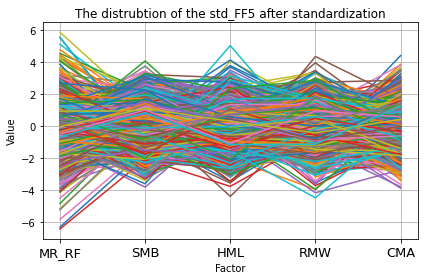

In [18]:
## Plot the distrubtion of the std_FF5 after standardization
std_FF5 = pd.DataFrame(std_FF5)
label = std_FF5.columns
index = std_FF5.index
std_FF5 = np.array(std_FF5).astype(float)

# Get the shape of std_FF5
shape = std_FF5.shape

for i in range(shape[0]):
    plt.plot(std_FF5[i,])   
plt.title('The distrubtion of the std_FF5 after standardization')
plt.xticks(np.arange(len(label)), label ,fontsize = 13)
plt.xlabel('Factor')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
predict_ERi = pd.Series(df_betas.iloc[:,0].values) + pd.Series(beta_lambda.iloc[:,0].values)
resids = df_Ex_SR.loc[:,df_betas.index].apply(lambda x: x-predict_ERi.values, axis = 1)
resids

Stocks,ABC.SJ.Equity,ABI.SJ.Equity,ABK.SJ.Equity,ABR.SJ.Equity,ABU.SJ.Equity,ACE.SJ.Equity,ACL.SJ.Equity,ACP.SJ.Equity,ACR.SJ.Equity,ACS.SJ.Equity,...,WTC.SJ.Equity,WTL.SJ.Equity,YRK.SJ.Equity,ZED.SJ.Equity,ZGOVI.SJ.Equity,ZPT.SJ.Equity,ZRNHDG.SJ.Equity,ZRNPLY.SJ.Equity,ZRR.SJ.Equity,ZSA.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,-0.117657,-0.000202,NaN,0.000391,NaN,NaN,-0.081389,NaN,0.000195,NaN,...,0.000015,NaN,-0.000131,NaN,NaN,0.001288,NaN,NaN,-0.000125,-0.000266
2000-12-21,0.000126,-0.007370,NaN,0.000391,NaN,NaN,0.044972,NaN,0.000195,NaN,...,0.000015,NaN,-0.000131,NaN,NaN,0.058446,NaN,NaN,-0.000125,-0.000266
2000-12-22,0.000124,0.002192,NaN,0.000389,NaN,NaN,0.028850,NaN,0.000193,NaN,...,0.000013,NaN,-0.000133,NaN,NaN,-0.055872,NaN,NaN,-0.000127,-0.000268
2000-12-25,0.000124,-0.000204,NaN,0.000389,NaN,NaN,-0.000153,NaN,0.000193,NaN,...,0.000013,NaN,-0.000133,NaN,NaN,0.001286,NaN,NaN,-0.000127,-0.000268
2000-12-26,0.000124,-0.000204,NaN,0.000389,NaN,NaN,-0.000153,NaN,0.000193,NaN,...,0.000013,NaN,-0.000133,NaN,NaN,0.001286,NaN,NaN,-0.000127,-0.000268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,0.000202,-0.000125,0.001028,0.000467,0.000040,0.000015,0.002879,-0.000450,0.000271,0.000561,...,0.000092,0.000956,0.083327,0.014049,-0.000137,0.001364,0.000005,-0.000009,-0.000048,-0.000190
2019-02-28,0.000202,-0.000125,0.001028,0.000467,0.000040,0.000015,-0.000075,-0.000450,0.000271,0.000561,...,0.000092,0.000956,-0.000054,-0.002565,-0.000137,0.001364,0.000005,-0.000009,-0.000048,-0.000190
2019-03-01,0.000203,-0.000125,0.001029,0.000468,0.000041,0.000015,0.054459,-0.000449,0.000272,0.000562,...,0.000092,0.000956,-0.000054,0.013882,-0.000137,0.001365,0.000006,-0.000008,-0.000048,-0.000189


In [20]:
# # Plotting the residuals distribution
# ## Histogram plot
# residuals.hist()
# plt.show()
# ## Q-Q plot, normally distributed data appears as roughly a straight line
# qqplot(residuals)
# plt.show()
# ## Autocorrelation plot
# autocorrelation_plot(residuals)
# plt.show()

In [22]:
## residuals are not normally distributed
# self_JBtest(residuals)

In [23]:
rd_resids = resids
shape = rd_resids.shape

for j in tqdm(range(shape[1])):
    for i in range(shape[0]):
        if np.isnan(rd_resids.iloc[i,j]):
## Replace NAN with different random variables
            rd_resids.iloc[i,j] = np.random.randn()
rd_resids

100%|██████████| 830/830 [01:46<00:00,  7.80it/s]


Stocks,ABC.SJ.Equity,ABI.SJ.Equity,ABK.SJ.Equity,ABR.SJ.Equity,ABU.SJ.Equity,ACE.SJ.Equity,ACL.SJ.Equity,ACP.SJ.Equity,ACR.SJ.Equity,ACS.SJ.Equity,...,WTC.SJ.Equity,WTL.SJ.Equity,YRK.SJ.Equity,ZED.SJ.Equity,ZGOVI.SJ.Equity,ZPT.SJ.Equity,ZRNHDG.SJ.Equity,ZRNPLY.SJ.Equity,ZRR.SJ.Equity,ZSA.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,-0.117657,-0.000202,-0.920466,0.000391,-1.285809,1.670002,-0.081389,-0.779984,0.000195,-0.115942,...,0.000015,-0.682394,-0.000131,0.364035,1.093615,0.001288,0.179143,-0.630127,-0.000125,-0.000266
2000-12-21,0.000126,-0.007370,-0.630331,0.000391,-0.751965,-0.031062,0.044972,-0.379547,0.000195,-0.919297,...,0.000015,0.592287,-0.000131,1.439647,-1.110987,0.058446,1.181395,0.808540,-0.000125,-0.000266
2000-12-22,0.000124,0.002192,1.842039,0.000389,-0.979169,0.137840,0.028850,0.070078,0.000193,-1.383171,...,0.000013,0.456761,-0.000133,0.182389,0.835829,-0.055872,0.338919,0.673059,-0.000127,-0.000268
2000-12-25,0.000124,-0.000204,-1.527759,0.000389,0.120288,0.641738,-0.000153,-0.914222,0.000193,-0.274770,...,0.000013,0.706407,-0.000133,0.504766,0.478139,0.001286,0.652924,1.309402,-0.000127,-0.000268
2000-12-26,0.000124,-0.000204,0.345112,0.000389,-1.635415,0.630294,-0.000153,-0.929113,0.000193,-0.217857,...,0.000013,-1.034950,-0.000133,0.428737,0.978282,0.001286,0.606767,-0.565329,-0.000127,-0.000268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,0.000202,-0.000125,0.001028,0.000467,0.000040,0.000015,0.002879,-0.000450,0.000271,0.000561,...,0.000092,0.000956,0.083327,0.014049,-0.000137,0.001364,0.000005,-0.000009,-0.000048,-0.000190
2019-02-28,0.000202,-0.000125,0.001028,0.000467,0.000040,0.000015,-0.000075,-0.000450,0.000271,0.000561,...,0.000092,0.000956,-0.000054,-0.002565,-0.000137,0.001364,0.000005,-0.000009,-0.000048,-0.000190
2019-03-01,0.000203,-0.000125,0.001029,0.000468,0.000041,0.000015,0.054459,-0.000449,0.000272,0.000562,...,0.000092,0.000956,-0.000054,0.013882,-0.000137,0.001365,0.000006,-0.000008,-0.000048,-0.000189


In [24]:
GRS_test(factor = df_FF5, resid = rd_resids, alpha = all_betas[0].iloc[:,0])

(95.76472658930325, 1.1102230246251565e-16)

In [25]:
stats.ttest_1samp(all_betas[0].iloc[:,0], 0.0)

Ttest_1sampResult(statistic=-6.061833230310968, pvalue=2.042072036157278e-09)